In [29]:
import matplotlib.pyplot as plt
import pandas as pd

import datetime

import config_error_by_period as config

In [30]:
def load_csv_data(path: str) -> pd.core.frame.DataFrame:
    """Load CSV dataset as dataframe"""
    return pd.read_csv(path, delimiter=',')

In [31]:
def generate_daily_labels(start_date, end_date):
    """Generate a list of daily labels between the start date and end date."""
    delta = end_date - start_date
    return [(start_date + datetime.timedelta(days=i)).isoformat() for i in range(delta.days + 1)]

def calculate_daily_average_error(csv_path: str) -> pd.Series:
    df = load_csv_data(csv_path)

    error_data_start = config.error_abs_start
    error_data_end = config.error_abs_end
    error_data = df.iloc[error_data_start-1:error_data_end]
    error_data.reset_index(drop=True, inplace=True)

    # Calculate average error for every 15-minute interval
    daily_errors = error_data.iloc[:, 3:].mean(axis=1)

    # Accumulate data for each day (96 time points per day)
    daily_sum = daily_errors.groupby(daily_errors.index // 96).sum()

    # Calculate the number of data points for each day
    daily_counts = daily_errors.groupby(daily_errors.index // 96).count()

    if daily_counts.iloc[-1] != 96:
        daily_sum = daily_sum.iloc[:-1]
        daily_counts = daily_counts.iloc[:-1]

    # Calculate daily average error (average of (10) trials for each day)
    daily_average_error = daily_sum / config.nTrial


    return daily_average_error

def plot_error_by_daily_with_cla_labels(case_paths, cla_labels) -> None:
    plt.figure(figsize=(10, 6))

    for i, path in enumerate(case_paths):
        # Calculate daily average error
        daily_average_error = calculate_daily_average_error(path)

        # Plot daily average error
        plt.plot(daily_average_error, label=cla_labels[i], color=config.label_color_map[cla_labels[i]])

    plt.xlabel("Days")
    plt.ylabel("Average Error [MW]")
    plt.title("Daily Average Error")
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_error_by_daily_with_actual_dates(case_paths, cla_labels, days_interval=30):
    plt.figure(figsize=(10, 6))

    start_date = datetime.date(2007, 5, 1)
    end_date = datetime.date(2019, 2, 28)
    daily_labels = generate_daily_labels(start_date, end_date)
    x_ticks = range(len(daily_labels))

    displayed_labels = [label if i % days_interval == 0 else '' for i, label in enumerate(daily_labels)]

    for i, path in enumerate(case_paths):
        daily_average_error = calculate_daily_average_error(path)
        min_length = min(len(x_ticks), len(daily_average_error))
        plt.plot(x_ticks[:min_length], daily_average_error[:min_length], label=cla_labels[i], color=config.label_color_map[cla_labels[i]])

    plt.xticks(x_ticks, displayed_labels, rotation=45)
    plt.xlabel("Date")
    plt.ylabel("Average Error [MW]")
    plt.title("Daily Average Error with Actual Dates")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [32]:
def days_in_month(year, month):
    """Return the number of days in a given month, accounting for leap years."""
    if month == 2:  # February
        return 29 if year % 4 == 0 and (year % 100 != 0 or year % 400 == 0) else 28
    elif month in [4, 6, 9, 11]:  # April, June, September, November
        return 30
    else:
        return 31

def generate_month_labels(start_year, start_month, end_year, end_month):
    """Generate a list of month labels from start year/month to end year/month."""
    labels = []
    year = start_year
    month = start_month
    while year < end_year or (year == end_year and month <= end_month):
        labels.append(f"{year}-{month:02d}")
        month += 1
        if month > 12:
            month = 1
            year += 1
    return labels

def calculate_monthly_average_error(csv_path: str) -> pd.Series:
    df = load_csv_data(csv_path)

    error_data_start = config.error_abs_start
    error_data_end = config.error_abs_end
    error_data = df.iloc[error_data_start-1:error_data_end]

    error_data.reset_index(drop=True, inplace=True)

    # Calculate average error for every 15-minute interval
    monthly_errors = error_data.iloc[:, 3:].mean(axis=1)

    # Initialize variables
    monthly_average_errors = []
    current_month = 5  # Starting month (May 2007)
    current_year = 2007  # Starting year
    index = 0

    # Iterate over each month
    while current_year < 2019 or (current_year == 2019 and current_month <= 2):
        days = days_in_month(current_year, current_month)
        time_points = days * 96  # 96 time points per day

        # Sum errors for the month
        monthly_sum = monthly_errors.iloc[index:index + time_points].sum()
        monthly_average = monthly_sum / (config.nTrial * days)
        monthly_average_errors.append(monthly_average)

        # Update for next month
        index += time_points
        current_month += 1
        if current_month > 12:
            current_month = 1
            current_year += 1

    return pd.Series(monthly_average_errors)

def plot_error_by_month_with_cla_labels(case_paths, cla_labels):
    plt.figure(figsize=(10, 6))

    for i, path in enumerate(case_paths):
        # Calculate monthly average error
        monthly_average_error = calculate_monthly_average_error(path)

        # Plot monthly average error
        plt.plot(monthly_average_error, label=cla_labels[i], color=config.label_color_map[cla_labels[i]])

    plt.xlabel("Months")
    plt.ylabel("Average Error [MW]")
    plt.title("Monthly Average Error")
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_error_by_month_with_actual_dates(case_paths, cla_labels, month_interval=3):
    plt.figure(figsize=(10, 6))

    month_labels = generate_month_labels(2007, 5, 2019, 2)
    x_ticks = range(len(month_labels))

    displayed_labels = [label if i % month_interval == 0 else '' for i, label in enumerate(month_labels)]

    for i, path in enumerate(case_paths):
        monthly_average_error = calculate_monthly_average_error(path)
        plt.plot(x_ticks, monthly_average_error, label=cla_labels[i], color=config.label_color_map[cla_labels[i]])

    plt.xticks(x_ticks, displayed_labels, rotation=45)
    plt.xlabel("Months")
    plt.ylabel("Average Error [MW]")
    plt.title("Monthly Average Error with Actual Dates")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Case 1

In [33]:
case1_df = load_csv_data(config.case1_error_by_period_path)
case1_df

,Unnamed: 0,TRUE,Unnamed: 2,1,2,3,4,5,6,7,8,9,10,Unnamed: 13
0,1,4854.40,NaN,4854.4000,4854.4000,4854.4000,4854.4000,4854.4000,4854.4000,4854.4000,4854.4000,4854.4000,4854.4000,NaN
1,2,4777.37,NaN,4777.3700,4777.3700,4777.3700,4777.3700,4777.3700,4777.3700,4777.3700,4777.3700,4777.3700,4777.3700,NaN
2,3,4729.48,NaN,4729.4800,4729.4800,4729.4800,4729.4800,4729.4800,4729.4800,4729.4800,4729.4800,4729.4800,4729.4800,NaN
3,4,4682.39,NaN,4682.3900,4682.3900,4682.3900,4682.3900,4682.3900,4682.3900,4682.3900,4682.3900,4682.3900,4682.3900,NaN
4,5,4587.34,NaN,4587.3400,4587.3400,4587.3400,4587.3400,4587.3400,4587.3400,4587.3400,4587.3400,4587.3400,4587.3400,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829826,414911,NaN,NaN,71.4631,71.4631,71.4631,71.4631,71.4631,71.4631,71.4631,71.4631,71.4631,71.4631,NaN
829827,414912,NaN,NaN,99.2539,99.2539,99.2539,99.2539,99.2539,99.2539,99.2539,99.2539,99.2539,99.2539,NaN
829828,414913,NaN,NaN,103.1790,103.1790,103.1790,103.1790,103.1790,103.1790,103.1790,103.1790,103.1790,103.1790,NaN
829829,414914,NaN,NaN,113.7220,113.7220,113.7220,113.7220,113.7220,113.7220,113.7220,113.7220,113.7220,113.7220,NaN


In [34]:
print(config.error_abs_start)
print(config.error_abs_end)

414916
829830


# Case 2

In [35]:
case2_df = load_csv_data(config.case2_error_by_period_path)
case2_df

,Unnamed: 0,TRUE,Unnamed: 2,1,2,3,4,5,6,7,8,9,10,Unnamed: 13
0,1,4854.40,NaN,4854.4000,4854.4000,4854.4000,4854.4000,4854.4000,4854.4000,4854.4000,4854.4000,4854.4000,4854.4000,NaN
1,2,4777.37,NaN,4777.3700,4777.3700,4777.3700,4777.3700,4777.3700,4777.3700,4777.3700,4777.3700,4777.3700,4777.3700,NaN
2,3,4729.48,NaN,4729.4800,4729.4800,4729.4800,4729.4800,4729.4800,4729.4800,4729.4800,4729.4800,4729.4800,4729.4800,NaN
3,4,4682.39,NaN,4682.3900,4682.3900,4682.3900,4682.3900,4682.3900,4682.3900,4682.3900,4682.3900,4682.3900,4682.3900,NaN
4,5,4587.34,NaN,4587.3400,4587.3400,4587.3400,4587.3400,4587.3400,4587.3400,4587.3400,4587.3400,4587.3400,4587.3400,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829826,414911,NaN,NaN,72.9062,72.9062,72.9062,72.9062,72.9062,72.9062,72.9062,72.9062,72.9062,72.9062,NaN
829827,414912,NaN,NaN,112.1160,112.1160,112.1160,112.1160,112.1160,112.1160,112.1160,112.1160,112.1160,112.1160,NaN
829828,414913,NaN,NaN,103.6380,103.6380,103.6380,103.6380,103.6380,103.6380,103.6380,103.6380,103.6380,103.6380,NaN
829829,414914,NaN,NaN,93.1827,157.0790,157.0790,157.0790,157.0790,157.0790,157.0790,157.0790,157.0790,157.0790,NaN


# Case 3

In [36]:
case3_df = load_csv_data(config.case3_error_by_period_path)
case3_df

,Unnamed: 0,TRUE,Unnamed: 2,1,2,3,4,5,6,7,8,9,10,Unnamed: 13
0,1,4854.40,NaN,4854.4000,4854.40000,4854.40000,4854.40000,4854.4000,4854.40000,4854.40000,4854.40000,4854.40000,4854.4000,NaN
1,2,4777.37,NaN,4777.3700,4777.37000,4777.37000,4777.37000,4777.3700,4777.37000,4777.37000,4777.37000,4777.37000,4777.3700,NaN
2,3,4729.48,NaN,4729.4800,4729.48000,4729.48000,4729.48000,4729.4800,4729.48000,4729.48000,4729.48000,4729.48000,4729.4800,NaN
3,4,4682.39,NaN,4682.3900,4682.39000,4682.39000,4682.39000,4682.3900,4682.39000,4682.39000,4682.39000,4682.39000,4682.3900,NaN
4,5,4587.34,NaN,4587.3400,4587.34000,4587.34000,4587.34000,4587.3400,4587.34000,4587.34000,4587.34000,4587.34000,4587.3400,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829826,414911,NaN,NaN,81.6749,3.21266,3.21266,68.53220,81.6749,7.48135,3.21266,7.48135,7.48135,81.6749,NaN
829827,414912,NaN,NaN,95.2489,15.13080,15.13080,11.25690,95.2489,3.39706,3.39706,15.13080,3.39706,95.2489,NaN
829828,414913,NaN,NaN,91.0721,20.36770,1.46828,10.26000,100.8330,10.22010,10.22010,64.39230,10.26000,91.0721,NaN
829829,414914,NaN,NaN,92.3722,8.09674,2.68075,2.68075,92.3722,17.31000,8.09674,54.93680,8.09674,92.3722,NaN


# Case 4

In [37]:
case4_df = load_csv_data(config.case4_error_by_period_path)
case4_df

,Unnamed: 0,TRUE,Unnamed: 2,1,2,3,4,5,6,7,8,9,10,Unnamed: 13
0,1,4854.40,NaN,4854.40000,4854.4000,4854.4000,4854.4000,4854.40000,4854.4000,4854.40000,4854.4000,4854.4000,4854.4000,NaN
1,2,4777.37,NaN,4777.37000,4777.3700,4777.3700,4777.3700,4777.37000,4777.3700,4777.37000,4777.3700,4777.3700,4777.3700,NaN
2,3,4729.48,NaN,4729.48000,4729.4800,4729.4800,4729.4800,4729.48000,4729.4800,4729.48000,4729.4800,4729.4800,4729.4800,NaN
3,4,4682.39,NaN,4682.39000,4682.3900,4682.3900,4682.3900,4682.39000,4682.3900,4682.39000,4682.3900,4682.3900,4682.3900,NaN
4,5,4587.34,NaN,4587.34000,4587.3400,4587.3400,4587.3400,4587.34000,4587.3400,4587.34000,4587.3400,4587.3400,4587.3400,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829826,414911,NaN,NaN,3.21266,81.6749,81.6749,81.6749,7.48135,74.0831,7.48135,81.6749,74.0831,81.6749,NaN
829827,414912,NaN,NaN,3.39706,95.2489,95.2489,95.2489,15.13080,95.2489,7.38306,95.2489,95.2489,85.5187,NaN
829828,414913,NaN,NaN,10.26000,100.8330,100.8330,100.8330,51.15210,100.8330,20.36770,91.0721,100.8330,100.8330,NaN
829829,414914,NaN,NaN,8.09674,92.3722,92.3722,92.3722,54.93680,92.3722,15.65420,92.3722,92.3722,92.3722,NaN


## Summary

In [38]:
# The following are the case labels you want to pass
# case_labels = ['Case 1', 'Case 2', 'Case 3', 'Case 4']
# case_labels = ['Case 1', 'Case 4']
# cla_labels = ['CLA(Fit)', 'CLA(Wide)', 'CLA(Narrow)', 'CLA-DR']
cla_labels = ['CLA(Fit)', 'CLA-DR']
# cla_labels = ['CLA(Fit)']

case_paths = [
    config.case1_error_by_period_path,
    # config.case2_error_by_period_path,
    # config.case3_error_by_period_path,
    config.case4_error_by_period_path
]


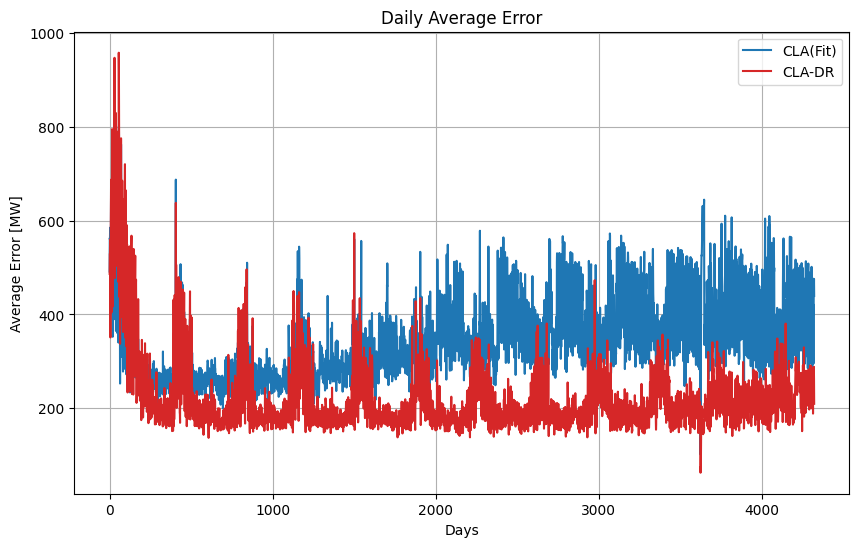

In [39]:
plot_error_by_daily_with_cla_labels(case_paths, cla_labels)

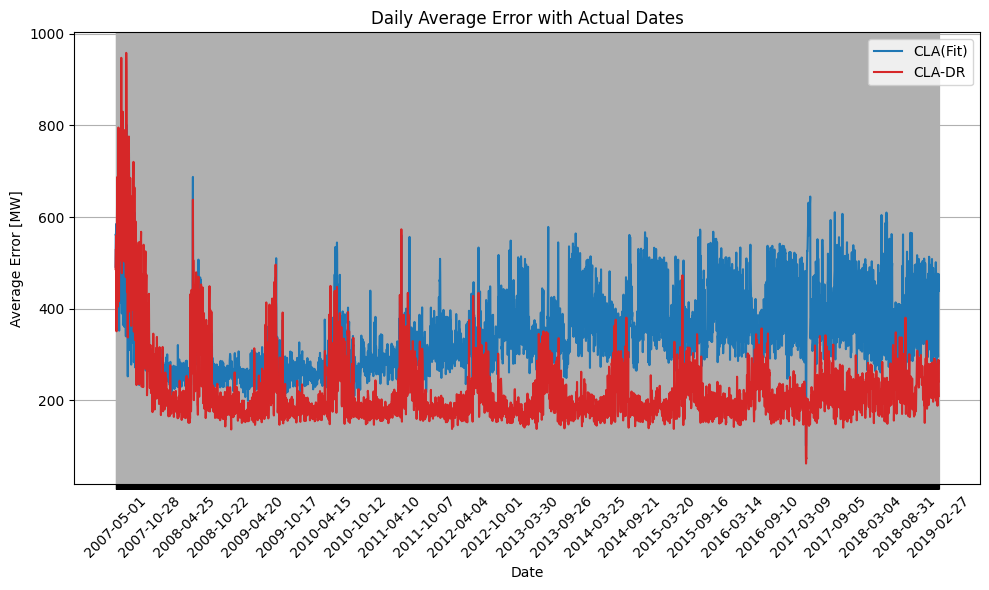

In [40]:
plot_error_by_daily_with_actual_dates(case_paths, cla_labels, days_interval=180)

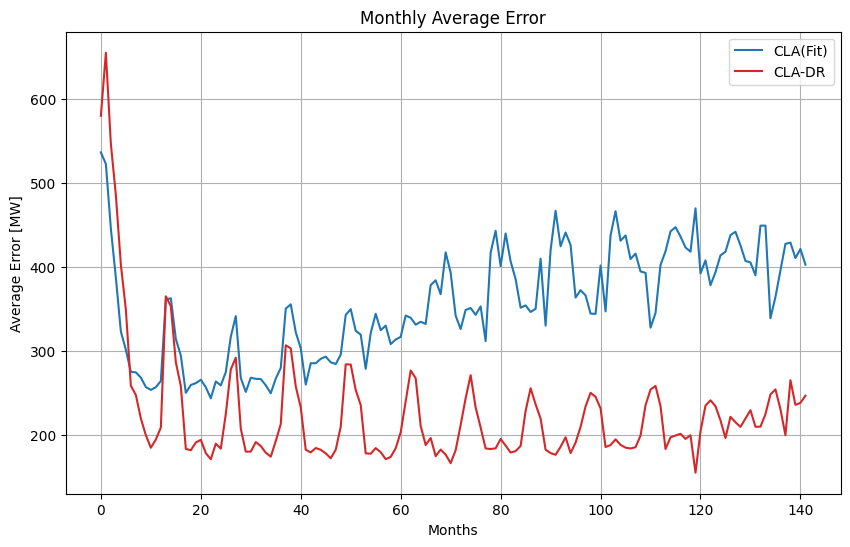

In [41]:
plot_error_by_month_with_cla_labels(case_paths, cla_labels)

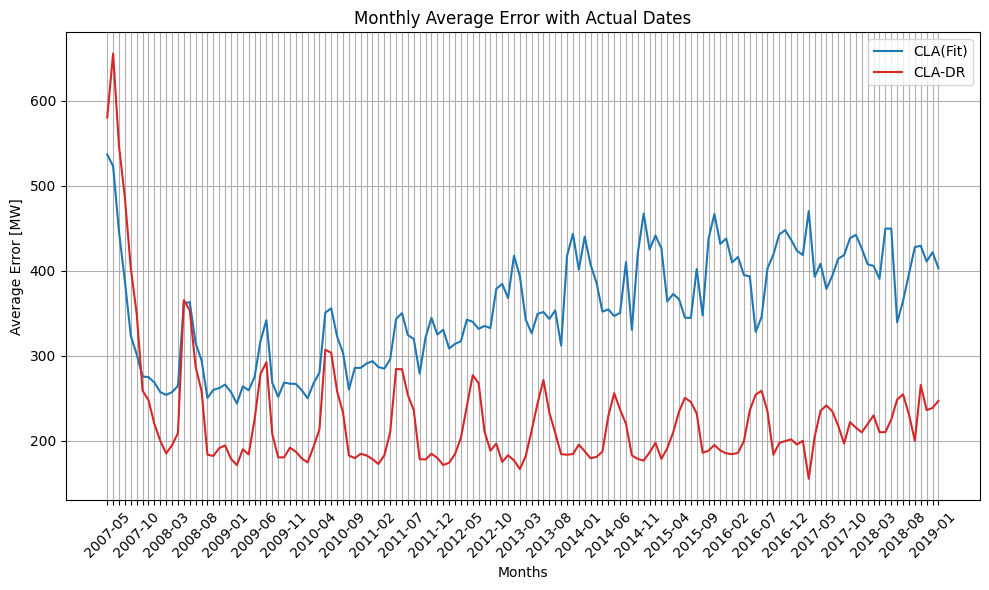

In [42]:
plot_error_by_month_with_actual_dates(case_paths, cla_labels, month_interval=5)